In [5]:
from openquantumcomputing import QAOAPortfolioOptimization, QAOABase
from openquantumcomputing import Statistic
import asset_loader

from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from tqdm import tqdm
import itertools


from importlib import reload

256


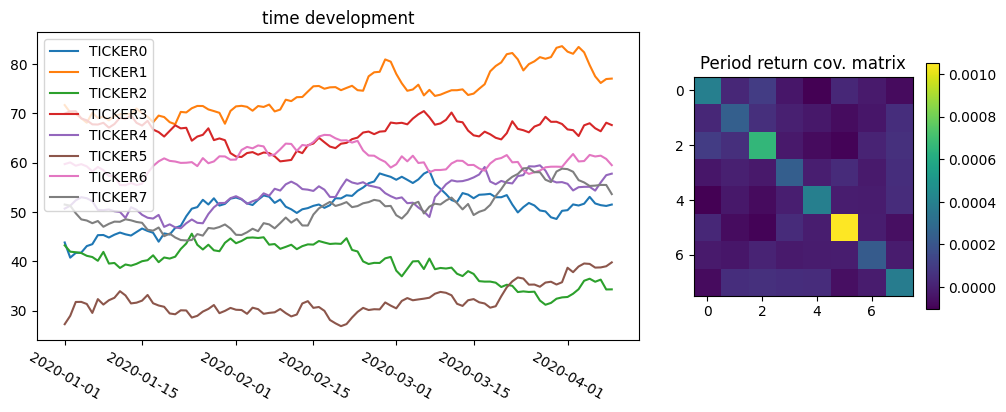

In [6]:
reload(asset_loader)
assets = asset_loader.AssetData(8, 100, seed=13)
assets.plotAssets()

params = {
    "risk" : 0.5,
    "budget": 3,
    "penalty": 0.1,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return,
    "usebarrier": True
}
print(2**assets.N)

In [10]:
reload(QAOAPortfolioOptimization)
qaoa_portopt = QAOAPortfolioOptimization.QAOAPortfolioOptimization(params)
print(qaoa_portopt)

In [11]:
display(qaoa_portopt.createParameterizedCircuit(1).draw(output='mpl'))


AttributeError: 'NoneType' object has no attribute 'draw'

In [ ]:

print("solutions:")
best_sol = None
best_cost = None
for s in [''.join(i) for i in itertools.product('01', repeat = assets.N)]:
    c = qaoa_portopt.cost(s)
    if best_sol is None:
        best_sol = s
        best_cost = c
    elif c > best_cost:
        best_sol = s
        best_cost = c

    if qaoa_portopt.isFeasible(s):
        print(s, c)
    else: 
        print(s, '\t', c)

print("--------------------")
print("Best sol is "+ best_sol + " with cost " + str(best_cost))

solutions:
00000000 	 -0.9000000000000001
00000001 	 -0.39959493903923593
00000010 	 -0.40003838680503623
00000011 	 -0.09961497100788397
00000100 	 -0.3961826539466855
00000101 	 -0.09571981905405957
00000110 	 -0.09620838012044663
00000111 0.004272809608567463
00001000 	 -0.3986812912588831
00001001 	 -0.09831678722260051
00001010 	 -0.09870341459236309
00001011 0.0016794442803078624
00001100 	 -0.0948507142301469
00001101 0.005571563737997387
00001110 0.005139823067648375
00001111 	 -0.09441954412781906
00010000 	 -0.4003413954515679
00010001 	 -0.09998313204490306
00010010 	 -0.10035871806754038
00010011 1.7900175512508554e-05
00010100 	 -0.09656304286303585
00010101 0.003852994475490812
00010110 0.003432295152266729
00010111 	 -0.09613331267281855
00011000 	 -0.09901744096566722
00011001 0.0013002655165159638
00011010 0.0009814998899164706
00011011 	 -0.09868243879151217
00011100 0.004774142598286346
00011101 	 -0.09485037698766874
00011110 	 -0.09521425591485477
00011111 	 -0.394

## Sample cost landscape

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')

In [ ]:
qaoa_portopt.sample_cost_landscape(qasm_sim, 1024, angles={"gamma": [0,np.pi,50], "beta": [0,np.pi,40]})

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done


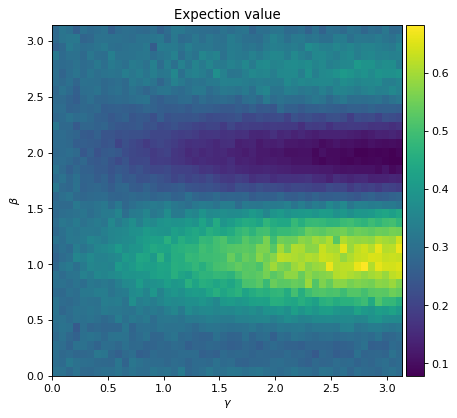

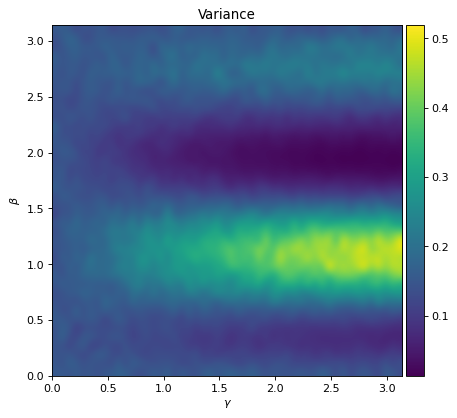

In [ ]:
def plotLandscape(field, title, interpolation='bicubic'):
    f = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    _=plt.xlabel(r'$\gamma$')
    _=plt.ylabel(r'$\beta$')
    ax = plt.gca()
    _=plt.title(title)
    im = ax.imshow(field, interpolation=interpolation, origin='lower', extent=[0,np.pi,0,np.pi])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _=plt.colorbar(im, cax=cax)

plotLandscape(qaoa_portopt.E, "Expection value", interpolation="None")
#plotLandscape(qaoa_portopt.E, r'CVaR with $\alpha$='+str(qaoaec_cvar.params["alpha"])) #, interpolation="None")
plotLandscape(qaoa_portopt.Var, "Variance")


In [ ]:
def searchBestSolution(qaoa, depth, verbose=0):
    # Verbose: 0 = None, 1 = Best only, 2 = all
    hist=qaoa.hist(qaoa.angles_hist['d'+str(depth)+'_final'], qasm_sim, 1024)
    sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

    if verbose > 1: print("Classical best result: ", (best_sol, best_cost))

    i = 0
    best_s = None
    best_freq = None
    best_i = None
    best_c = None
    for s, freq in sorted_hist.items():
        if s == best_sol:
            if verbose > 1: print(str(i)+" -->\t", qaoa.cost(s), s, freq)
            best_s, best_freq, best_i = s, freq, i
            best_c = qaoa.cost(best_s)
        elif i <= 30:
            if qaoa_portopt.isFeasible(s):
                if verbose > 1: print(str(i)+"\t", qaoa.cost(s), s, freq)
            else:
                if verbose > 1: print(str(i)+"\t\t", qaoa.cost(s), s, freq)
        i = i + 1
    if best_s is not None:
        if verbose > 0: print("Best sol (rank, cost, freq):", (best_i, qaoa.cost(best_s), best_freq))

    
    return best_s, best_freq, best_i, best_c

In [ ]:
qaoa_portopt.angles_hist

{}

In [ ]:
maxdepth=10
for i in tqdm(range(maxdepth)):
    qaoa_portopt.increase_depth(qasm_sim, 1024)
    searchBestSolution(qaoa_portopt, i+1, verbose=1)

 10%|█         | 1/10 [00:00<00:08,  1.06it/s]

cost(depth= 1 )= 0.08067517405076155
Best sol (rank, cost, freq): (50, 0.006864651880631345, 6)


 20%|██        | 2/10 [00:03<00:13,  1.70s/it]

cost(depth= 2 )= 0.10103095672695425
Best sol (rank, cost, freq): (56, 0.006864651880631345, 6)


 30%|███       | 3/10 [00:06<00:17,  2.56s/it]

cost(depth= 3 )= 0.12079932098816727
Best sol (rank, cost, freq): (42, 0.006864651880631345, 6)


 40%|████      | 4/10 [00:12<00:23,  3.86s/it]

cost(depth= 4 )= 0.11527252394282568
Best sol (rank, cost, freq): (114, 0.006864651880631345, 1)


 50%|█████     | 5/10 [00:22<00:30,  6.01s/it]

cost(depth= 5 )= 0.10170289526647305


 60%|██████    | 6/10 [00:37<00:36,  9.01s/it]

cost(depth= 6 )= 0.08807727137294126
Best sol (rank, cost, freq): (36, 0.006864651880631345, 3)


 70%|███████   | 7/10 [00:55<00:36, 12.12s/it]

cost(depth= 7 )= 0.1039965668251942


 80%|████████  | 8/10 [01:17<00:30, 15.15s/it]

cost(depth= 8 )= 0.09225442439271589
Best sol (rank, cost, freq): (150, 0.006864651880631345, 1)


 90%|█████████ | 9/10 [01:45<00:19, 19.19s/it]

cost(depth= 9 )= 0.13552138723821758
Best sol (rank, cost, freq): (16, 0.006864651880631345, 14)


100%|██████████| 10/10 [02:18<00:00, 13.86s/it]

cost(depth= 10 )= 0.17989536974217735
Best sol (rank, cost, freq): (8, 0.006864651880631345, 17)


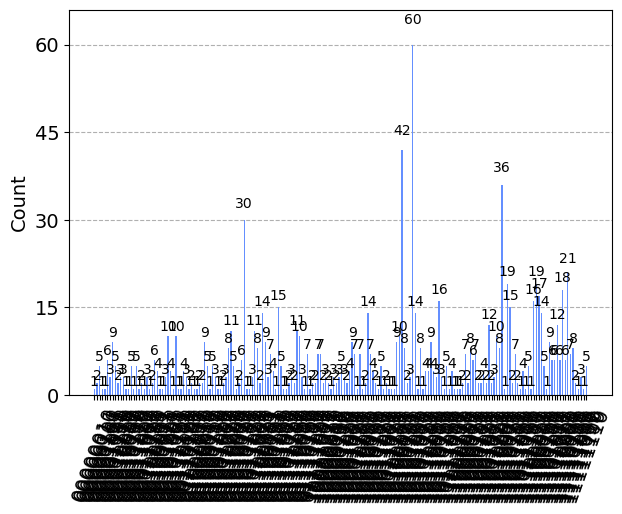

In [ ]:
hist=qaoa_portopt.hist(qaoa_portopt.angles_hist['d'+str(maxdepth)+'_final'], qasm_sim,1024)
plot_histogram(hist)

In [ ]:
sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

print("Classical best result: ", (best_sol, best_cost))

i = 0
best_s = None
best_freq = None
best_i = None
for s, freq in sorted_hist.items():
    if s == best_sol:
        print(str(i)+" -->\t", qaoa_portopt.cost(s), s, freq)
        best_s, best_freq, best_i = s, freq, i
    elif i <= 30:
        if qaoa_portopt.isFeasible(s):
            print(str(i)+"\t", qaoa_portopt.cost(s), s, freq)
        else:
            print(str(i)+"\t\t", qaoa_portopt.cost(s), s, freq)
    i = i + 1
if best_s is not None:
    print("Best sol (rank, cost, freq):", (best_i, qaoa_portopt.cost(best_s), best_freq))




Classical best result:  ('10001100', 0.006864651880631345)
0		 -0.09892834029424491 10101001 60
1	 0.0030902804805961193 10100100 42
2		 -0.0979214398809718 11010010 36
3		 -0.09573257650909128 01010110 30
4		 -0.39650347133530794 11110100 21
5		 -0.09414135963831538 11010100 19
6		 -0.09977288103841842 11100001 19
7		 -0.400095052474865 11110001 18
8		 -0.10013336680114415 11100010 17
9	 -0.0001448584652826712 11100000 16
10		 -0.3967993169187254 10110101 16
11		 -0.39370254126898563 11010101 15
12		 -0.09997484516477262 01101001 15
13		 -0.09618910398817793 11100100 14
14		 -0.09931487898812885 10101010 14
15	 -0.0013522162694326045 01100001 14
16	 0.005083153117060091 10010100 14
17		 -0.3946533082243009 11101100 12
18		 -0.395766928670757 11001011 12
19		 -0.09822012337979902 01011010 11
20	 0.0007033929974177289 01010001 11
21		 -0.10170985433451096 01110001 11
22	 0.0020368253931716263 11010000 10
23		 -0.10195588133790268 01110010 10
24		 -0.09665217985005481 00101101 10
25		 -0